<a href="https://colab.research.google.com/github/karabiniewicz/MACD_MoneyFlow_algorithm/blob/main/MN_P1_MACD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Opis:  Program zawierający implementacje wskaźnika MACD w języku Python, 
#       ocene, czy wskaźnik może być pomocny w analizie technicznej, 
#       oraz a zaproponowaniu algorytmu, który w sposób automatyczny 
#       na podstawie MACD podejmie decyzję o kupnie/sprzedaży akcji.

In [ ]:
#Potrzebne bibioteki:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.filterwarnings('ignore')

In [ ]:
#Wczytywanie danych
from google.colab import files
uploaded = files.upload()

In [ ]:
#Przypisanie ilosci linii
rows = 1000
#Zapisanie danych do df
df = pd.read_csv('wig20.csv')
#Ustawienie daty do indeksu
df = df.set_index(pd.DatetimeIndex(df['Data'].values))
#Pokaz danych 
df

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen
2017-02-22,2017-02-22,2252.57,2260.77,2231.02,2251.02,26211709
2017-02-23,2017-02-23,2249.81,2272.01,2241.82,2256.01,26058113
2017-02-24,2017-02-24,2252.39,2253.93,2202.39,2212.04,29656618
2017-02-27,2017-02-27,2212.87,2223.76,2199.40,2210.26,18271128
2017-02-28,2017-02-28,2214.22,2216.98,2187.79,2191.25,32147756
...,...,...,...,...,...,...
2021-02-22,2021-02-22,1978.70,1978.70,1958.36,1961.62,23606217
2021-02-23,2021-02-23,1969.01,1976.38,1896.36,1922.59,31468184
2021-02-24,2021-02-24,1926.18,1954.22,1924.64,1937.90,27510835
2021-02-25,2021-02-25,1955.61,1967.63,1936.13,1936.47,32921467


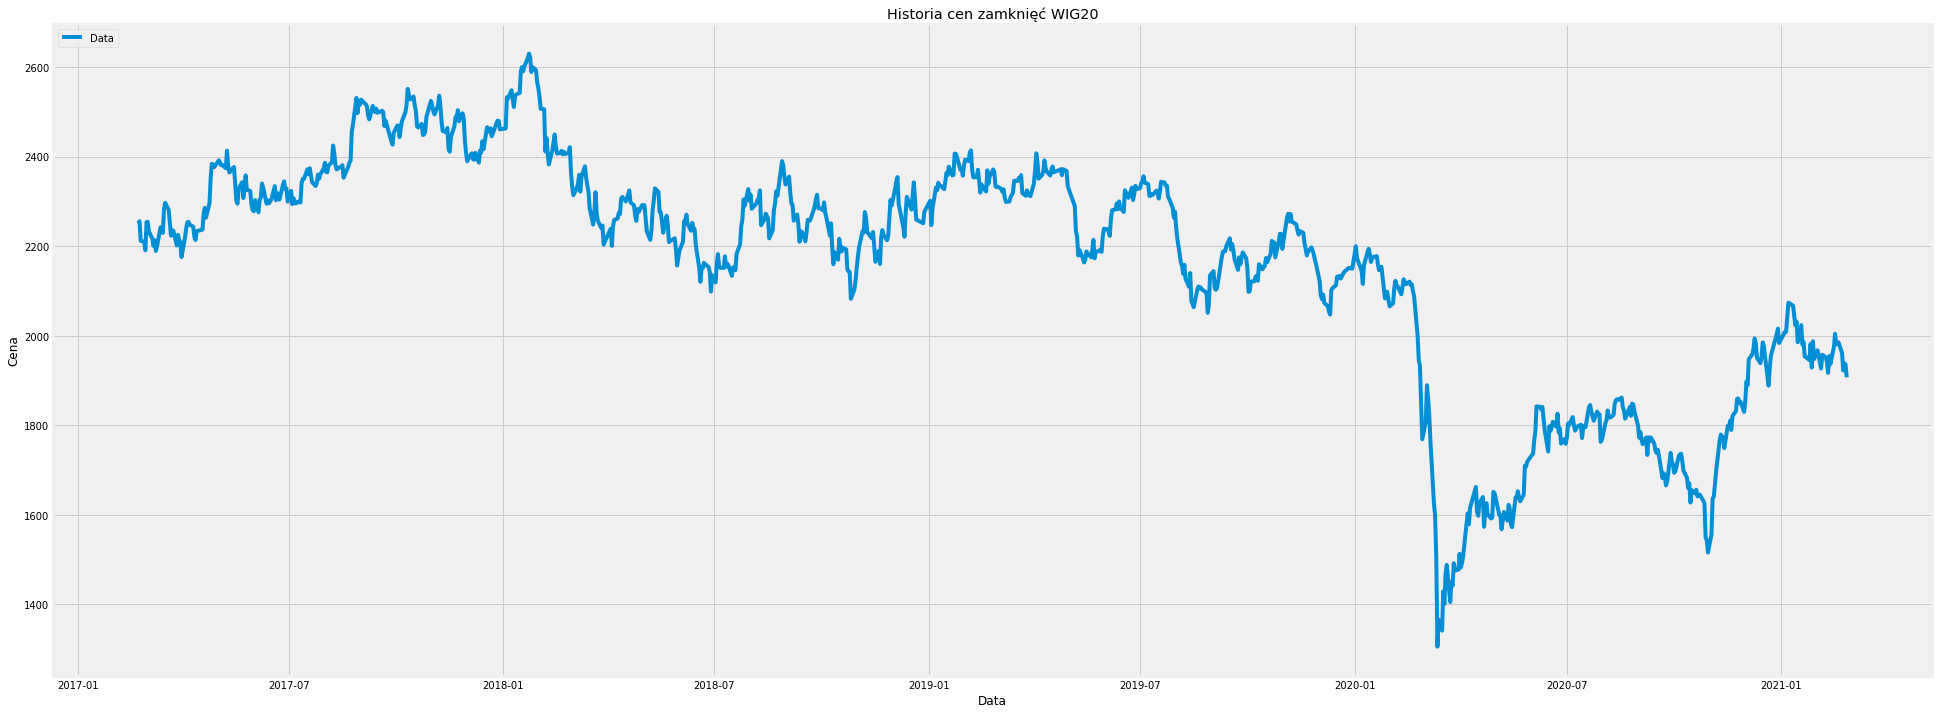

In [ ]:
#Pokazanie ceny akcji z ostatnich 1000 wierszy
plt.figure(figsize=(30, 12))
plt.plot(df['Zamkniecie'], label='Zamkniecie')
plt.title('Historia cen zamknięć WIG20')
plt.xlabel('Data')
plt.ylabel('Cena')
plt.legend(df.columns.values, loc = 'upper left')
plt.show()

In [ ]:
#Stworzenie funkcji która oblicza wykładniczą średnią kroczącą dla N okresów
def EMA(n, p, index):
  alpha = 2/(n+1)
  numerator = float(0.0)
  denominator =  float(0.0)
  for i in range(n):
      power = pow(1-alpha, i)
      denominator += power

      power *= p[index - i]
      numerator += power
  return float(numerator/denominator)

In [ ]:
df['MACD'] = [0.0] * rows
df['SIGNAL'] = [0.0] * rows

for i in range(26):
  df['MACD'][i] = np.NaN
  df['SIGNAL'][i] = np.NaN
for i in range(26, rows):
  df['MACD'][i] = EMA(12, df['Zamkniecie'], i) - EMA(26, df['Zamkniecie'], i)
for i in range(26, rows):
  df['SIGNAL'][i] = EMA(9, df['MACD'], i)
df

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen,MACD,SIGNAL
2017-02-22,2017-02-22,2252.57,2260.77,2231.02,2251.02,26211709,NaN,NaN
2017-02-23,2017-02-23,2249.81,2272.01,2241.82,2256.01,26058113,NaN,NaN
2017-02-24,2017-02-24,2252.39,2253.93,2202.39,2212.04,29656618,NaN,NaN
2017-02-27,2017-02-27,2212.87,2223.76,2199.40,2210.26,18271128,NaN,NaN
2017-02-28,2017-02-28,2214.22,2216.98,2187.79,2191.25,32147756,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-02-22,2021-02-22,1978.70,1978.70,1958.36,1961.62,23606217,6.106497,-0.289404
2021-02-23,2021-02-23,1969.01,1976.38,1896.36,1922.59,31468184,2.200949,0.865240
2021-02-24,2021-02-24,1926.18,1954.22,1924.64,1937.90,27510835,0.274221,1.274177
2021-02-25,2021-02-25,1955.61,1967.63,1936.13,1936.47,32921467,-0.999565,1.233530


In [ ]:
#Stworzenie funkcji która na podstawie SIGNAL i MACD wyznaczy kiedy kupić lub sprzedać akcje
def buy_sell_MACD(signal, budget):
  Buy = []
  Sell = []
  wallet = 0
  flag = 0            #zmienia sie tylko na przecieciu linii
  time_period = 0     #odstep pomiedzy zakupem a kupnem

  for i in range(0, len(signal)):
    if time_period > 0:
      time_period -= 1
    if signal['MACD'][i] > signal['SIGNAL'][i]:
      Sell.append(np.nan)
      if flag != 1 and time_period == 0:
        Buy.append(signal['Zamkniecie'][i+1])
        wallet = budget/signal['Zamkniecie'][i+1]
        flag = 1
        time_period = 1
      else:
        Buy.append(np.nan)
    elif signal['MACD'][i] < signal['SIGNAL'][i]:
      Buy.append(np.nan)
      if flag != 0 and time_period == 0:
        Sell.append(signal['Zamkniecie'][i+1])
        budget = round(wallet*signal['Zamkniecie'][i+1], 2)
        flag = 0
        time_period = 1
      else:
        Sell.append(np.nan)
    else:
      Buy.append(np.nan)
      Sell.append(np.nan)

  return (Buy, Sell, budget)

In [ ]:
#Dodanie kolumny sprzedaży, kupna oraz wyliczenie uzyskanego budżetu 
a = buy_sell_MACD(df, 1000)
df['Sygnal_Kupna'] = a[0]
df['Sygnal_Sprzedazy'] = a[1]
budget = a[2]
budget

994.33

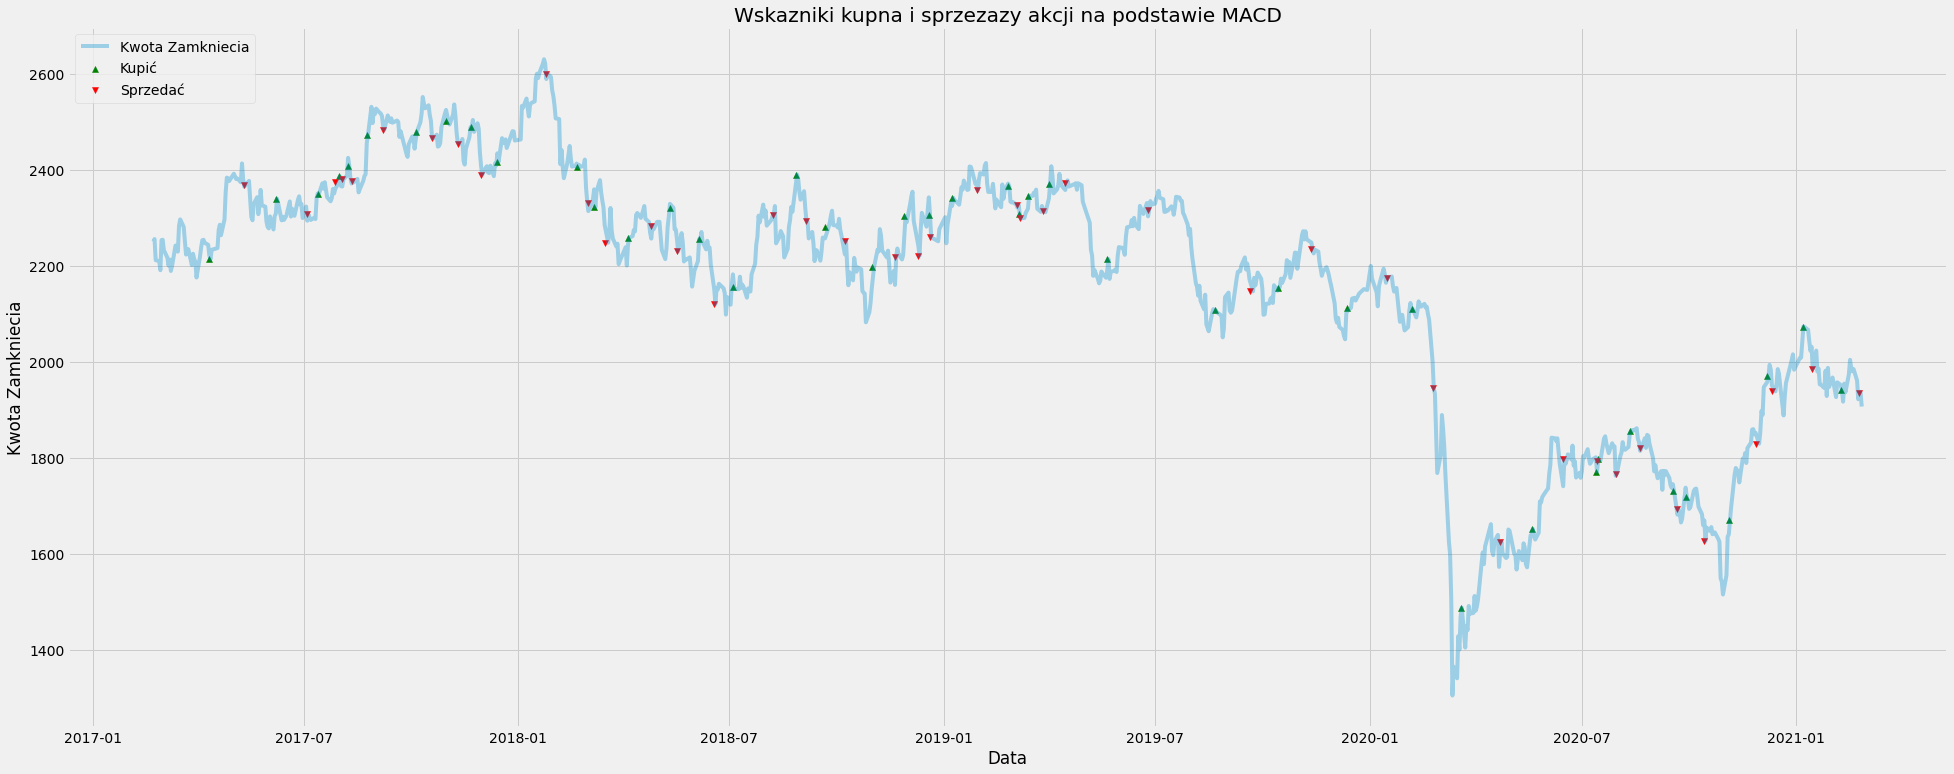

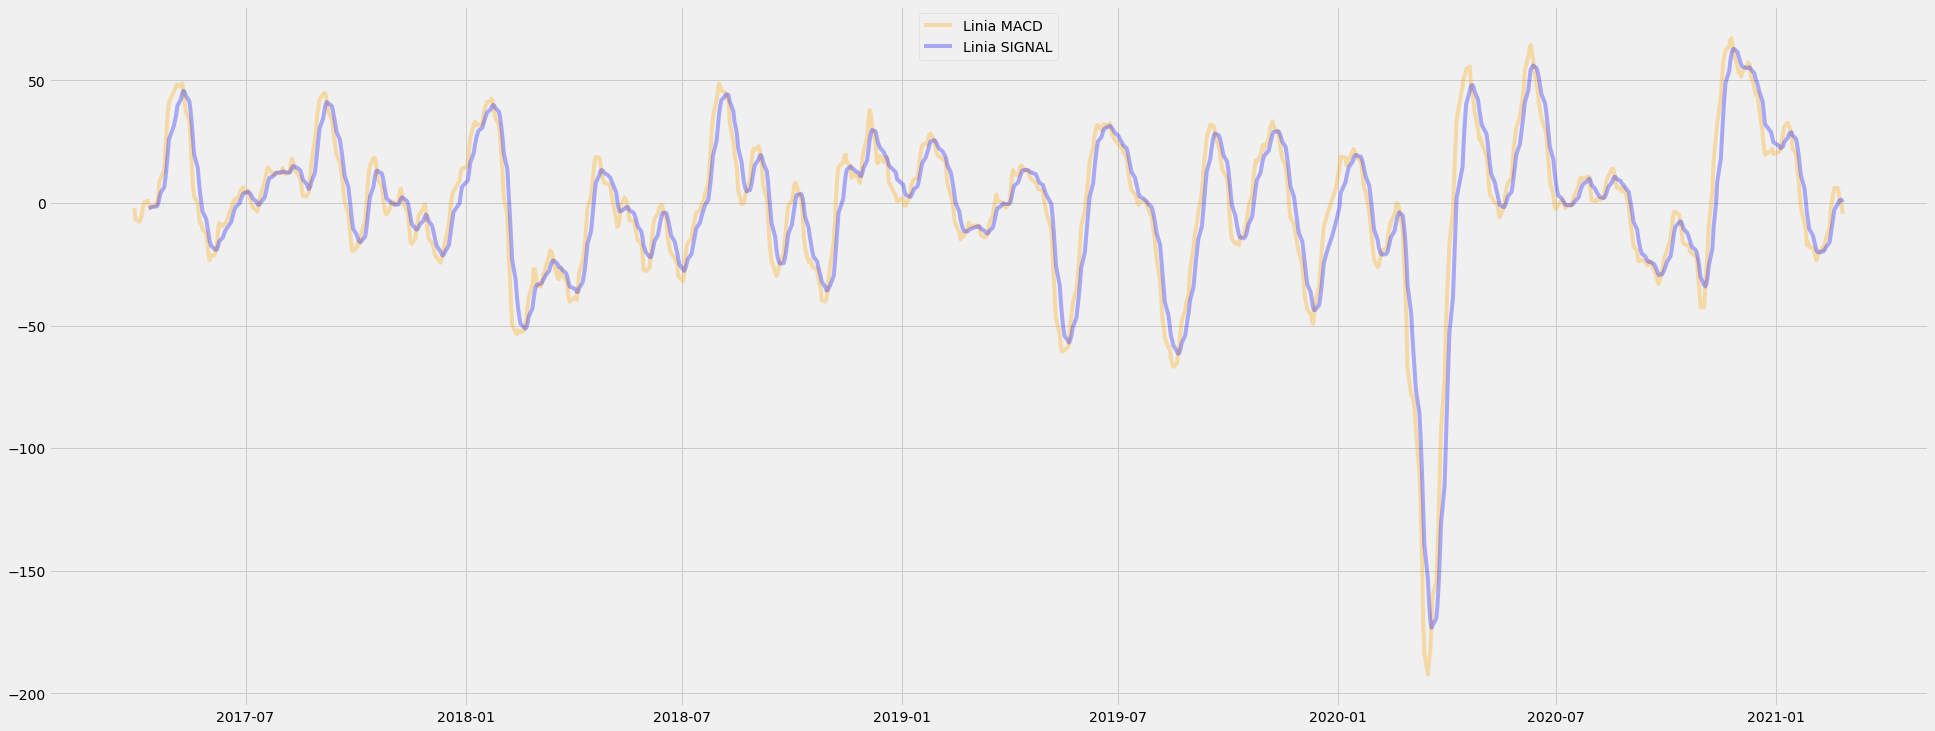

In [ ]:
#Wizualizacja kiedy kupic i sprzedac akcje
plt.figure(figsize=(30, 12))
plt.scatter(df.index, df['Sygnal_Kupna'], color = 'green', label='Kupić', marker='^', alpha=1)
plt.scatter(df.index, df['Sygnal_Sprzedazy'], color = 'red', label='Sprzedać', marker='v', alpha=1)
plt.plot(df['Zamkniecie'], label='Kwota Zamkniecia', alpha=0.35)
plt.title('Wskazniki kupna i sprzezazy akcji na podstawie MACD')
plt.xlabel('Data')
plt.ylabel('Kwota Zamkniecia')
plt.legend(loc = 'upper left')
plt.show()
#Rysowanie wykresu Linia MACD i SIGNAL
plt.figure(figsize=(30, 12))
plt.plot(df.index, df['MACD'], label = 'Linia MACD', color = 'orange',alpha=0.3)
plt.plot(df.index, df['SIGNAL'], label = 'Linia SIGNAL', color = 'blue',alpha=0.3)
plt.legend(loc = 'upper center')
plt.show()

In [ ]:
# Wyliczenie typowej ceny
typical_price = (df["Zamkniecie"] + df['Najnizszy'] + df['Najwyzszy']) / 3
typical_price

2017-02-22    2247.603333
2017-02-23    2256.613333
2017-02-24    2222.786667
2017-02-27    2211.140000
2017-02-28    2198.673333
                 ...     
2021-02-22    1966.226667
2021-02-23    1931.776667
2021-02-24    1938.920000
2021-02-25    1946.743333
2021-02-26    1908.243333
Length: 1000, dtype: float64

In [ ]:
# Ustawienie okresu i wyliczenie przepływu pieniędzy
period = 14

money_flow = typical_price * df['Wolumen']
money_flow

2017-02-22    5.891352e+10
2017-02-23    5.880309e+10
2017-02-24    6.592034e+10
2017-02-27    4.040002e+10
2017-02-28    7.068241e+10
                  ...     
2021-02-22    4.641517e+10
2021-02-23    6.078950e+10
2021-02-24    5.334131e+10
2021-02-25    6.408965e+10
2021-02-26    1.037964e+11
Length: 1000, dtype: float64

In [ ]:
# Wyznaczenie pozytywnego i negatywnego przepływu pieniędzy
positive_flow = []
negative_flow = []

for i in range(1, len(typical_price)):
  if typical_price[i] > typical_price[i-1]:
    positive_flow.append(money_flow[i-1])
    negative_flow.append(0)
  elif typical_price[i] < typical_price[i-1]:
    negative_flow.append(money_flow[i-1])
    positive_flow.append(0)
  else:
    positive_flow.append(0)
    negative_flow.append(0)

In [ ]:
# Dodanie do przepływu ograniczenia na okres czasu
positive_mf = []
negative_mf = []

for i in range(period - 1, len(positive_flow)):
  positive_mf.append(sum(positive_flow[i+1 - period : i+1]))
for i in range(period - 1, len(negative_flow)):
  negative_mf.append(sum(negative_flow[i+1 - period : i+1]))

In [ ]:
# Wyliczenie indeksu przepływu pieniędzy (MFI)
mfi = 100 * (np.array(positive_mf) / (np.array(positive_mf) + np.array(negative_mf)) )
# Sprawdzenie poprawnosci danych wyjsciowych
mfi[:10]

array([50.11737805, 42.45844639, 48.99192771, 56.55756589, 50.69726359,
       45.14703914, 38.10407566, 45.52558257, 52.78969544, 53.99302678])

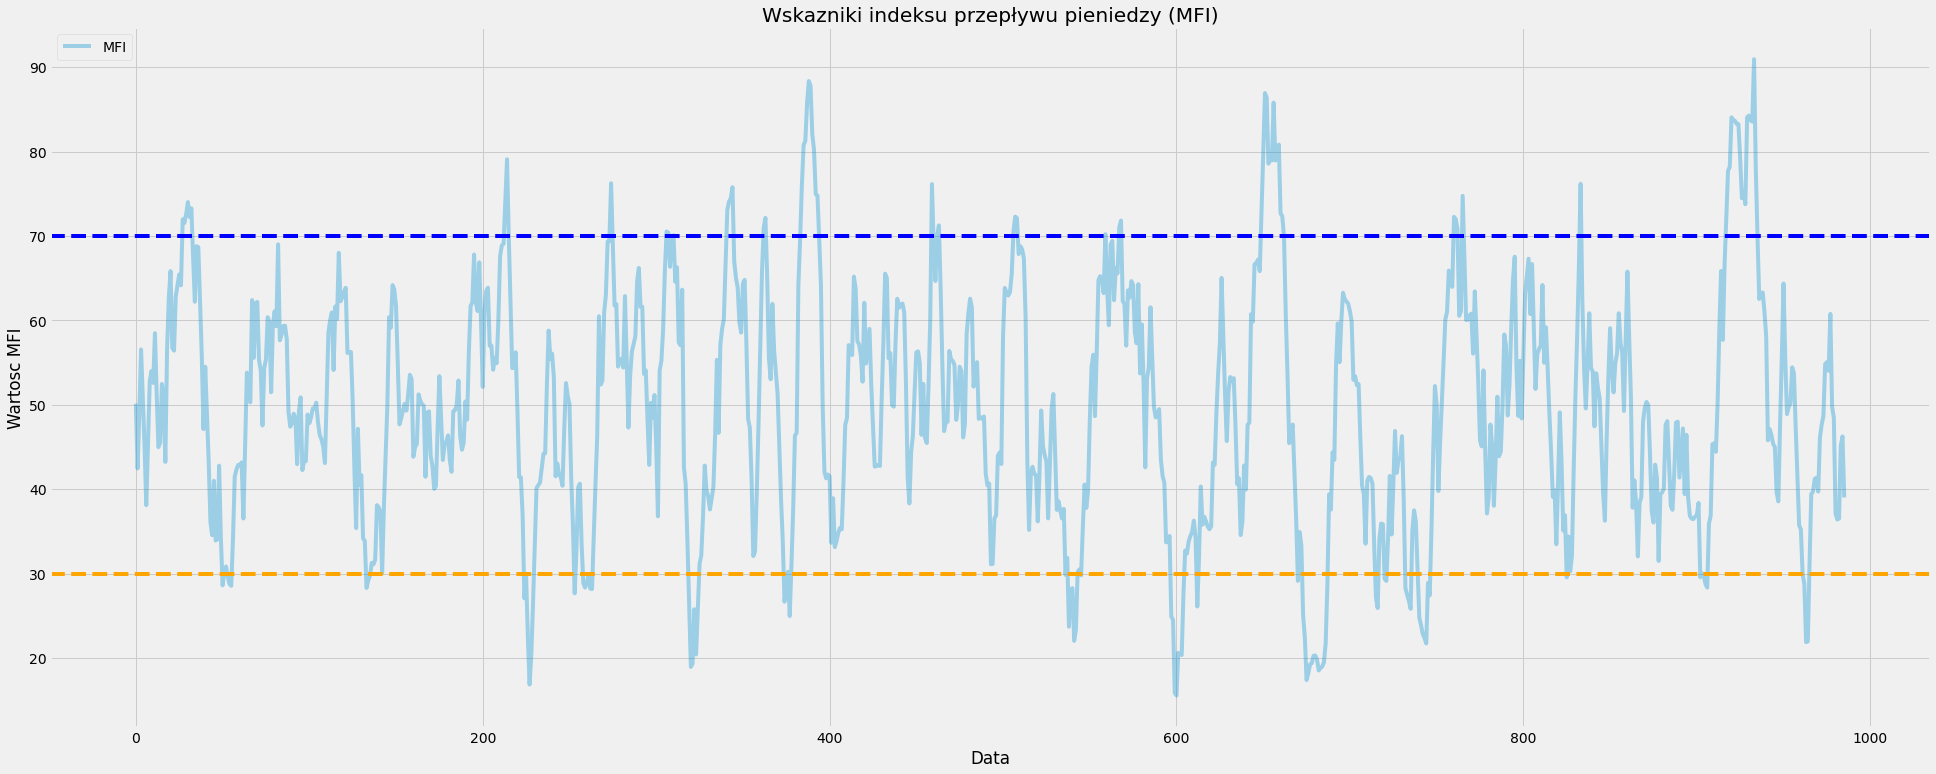

In [ ]:
# Wizualizacja indeksu przepływu pieniędzy(MFI) dla WIG20
df2 = pd.DataFrame()
df2['MFI'] = mfi
plt.figure(figsize=(30, 12))
plt.plot(df2['MFI'], label='MFI', alpha=0.35)
plt.title('Wskazniki indeksu przepływu pieniedzy (MFI)')
plt.axhline(30, linestyle = '--', color = 'orange')
plt.axhline(70, linestyle = '--', color = 'blue')
plt.xlabel('Data')
plt.ylabel('Wartosc MFI')
plt.legend( loc = 'upper left')
plt.show()

In [ ]:
# Nowe DataFrame
new_df = pd.DataFrame()
new_df = df[period:]
new_df['MFI'] = mfi
new_df

,Data,Otwarcie,Najwyzszy,Najnizszy,Zamkniecie,Wolumen,MACD,SIGNAL,Sygnal_Kupna,Sygnal_Sprzedazy,MFI
2017-03-14,2017-03-14,2242.95,2249.26,2228.74,2238.38,34980452,NaN,NaN,NaN,NaN,50.117378
2017-03-15,2017-03-15,2244.71,2246.33,2228.72,2229.87,26088999,NaN,NaN,NaN,NaN,42.458446
2017-03-16,2017-03-16,2246.85,2285.17,2246.85,2283.70,30882447,NaN,NaN,NaN,NaN,48.991928
2017-03-17,2017-03-17,2285.74,2308.92,2284.23,2296.97,62883209,NaN,NaN,NaN,NaN,56.557566
2017-03-20,2017-03-20,2294.85,2295.07,2265.28,2281.45,16461569,NaN,NaN,NaN,NaN,50.697264
...,...,...,...,...,...,...,...,...,...,...,...
2021-02-22,2021-02-22,1978.70,1978.70,1958.36,1961.62,23606217,6.106497,-0.289404,NaN,NaN,36.409028
2021-02-23,2021-02-23,1969.01,1976.38,1896.36,1922.59,31468184,2.200949,0.865240,NaN,NaN,36.509073
2021-02-24,2021-02-24,1926.18,1954.22,1924.64,1937.90,27510835,0.274221,1.274177,NaN,1936.47,45.179155
2021-02-25,2021-02-25,1955.61,1967.63,1936.13,1936.47,32921467,-0.999565,1.233530,NaN,NaN,46.246389


In [ ]:
# Stworzenie nowej funkcji która na podstawie MFI wyznaczy kiedy kupić lub sprzedać akcje
def buy_sell_mfi(data, high, low, budget):
  buy_signal = []
  sell_signal = []
  wallet = 0
  flag = 0            #zmienia sie tylko przy transakcji

  for i in range(len(data['MFI'])):
    if data['MFI'][i] > high:
      buy_signal.append(np.nan)
      if flag != 0:
        sell_signal.append(data['Zamkniecie'][i+1])
        budget = round(wallet*data['Zamkniecie'][i+1], 2)
        flag = 0
      else:
        sell_signal.append(np.nan)
    elif data['MFI'][i] < low:
      if flag != 1:
        buy_signal.append(data['Zamkniecie'][i+1])
        wallet = budget/data['Zamkniecie'][i+1]
        flag = 1
      else:
        buy_signal.append(np.nan)
      sell_signal.append(np.nan)
    else:
      buy_signal.append(np.nan)
      sell_signal.append(np.nan)
  
  return (buy_signal, sell_signal, budget)

In [ ]:
#Nowe sygnały kupna i sprzedaży
mfi_results = buy_sell_mfi(new_df, 70, 30, 1000)
new_df['Sygnal_Kupna_MFI'] = mfi_results[0]
new_df['Sygnal_Sprzedazy_MFI'] = mfi_results[1]
budget2 = mfi_results[2]
budget2


1061.86

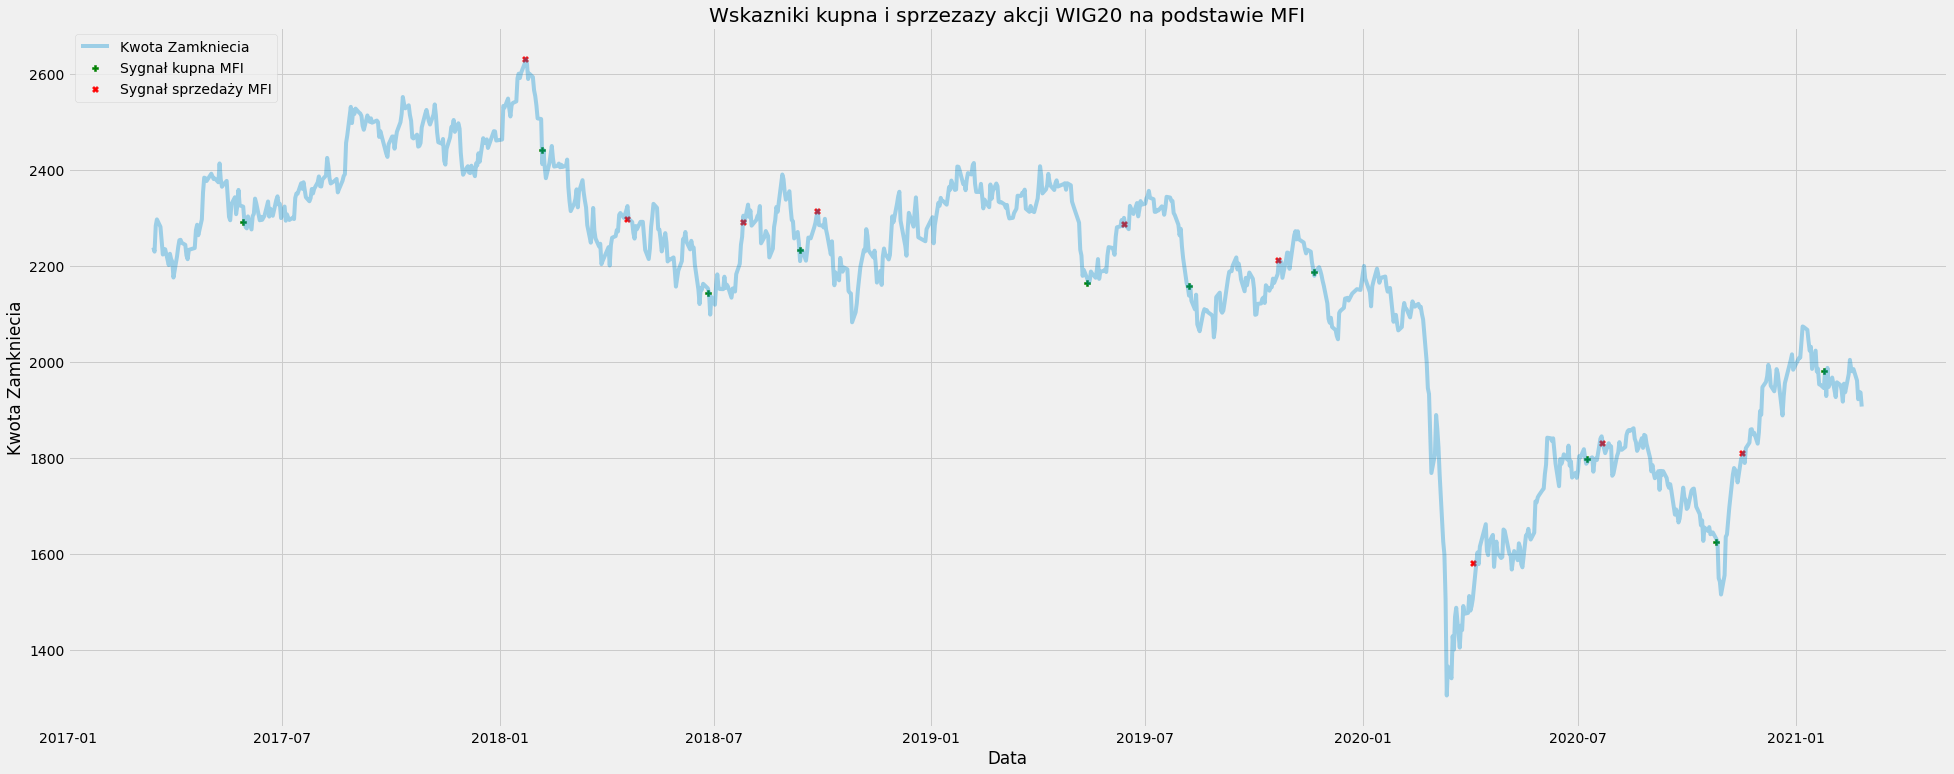

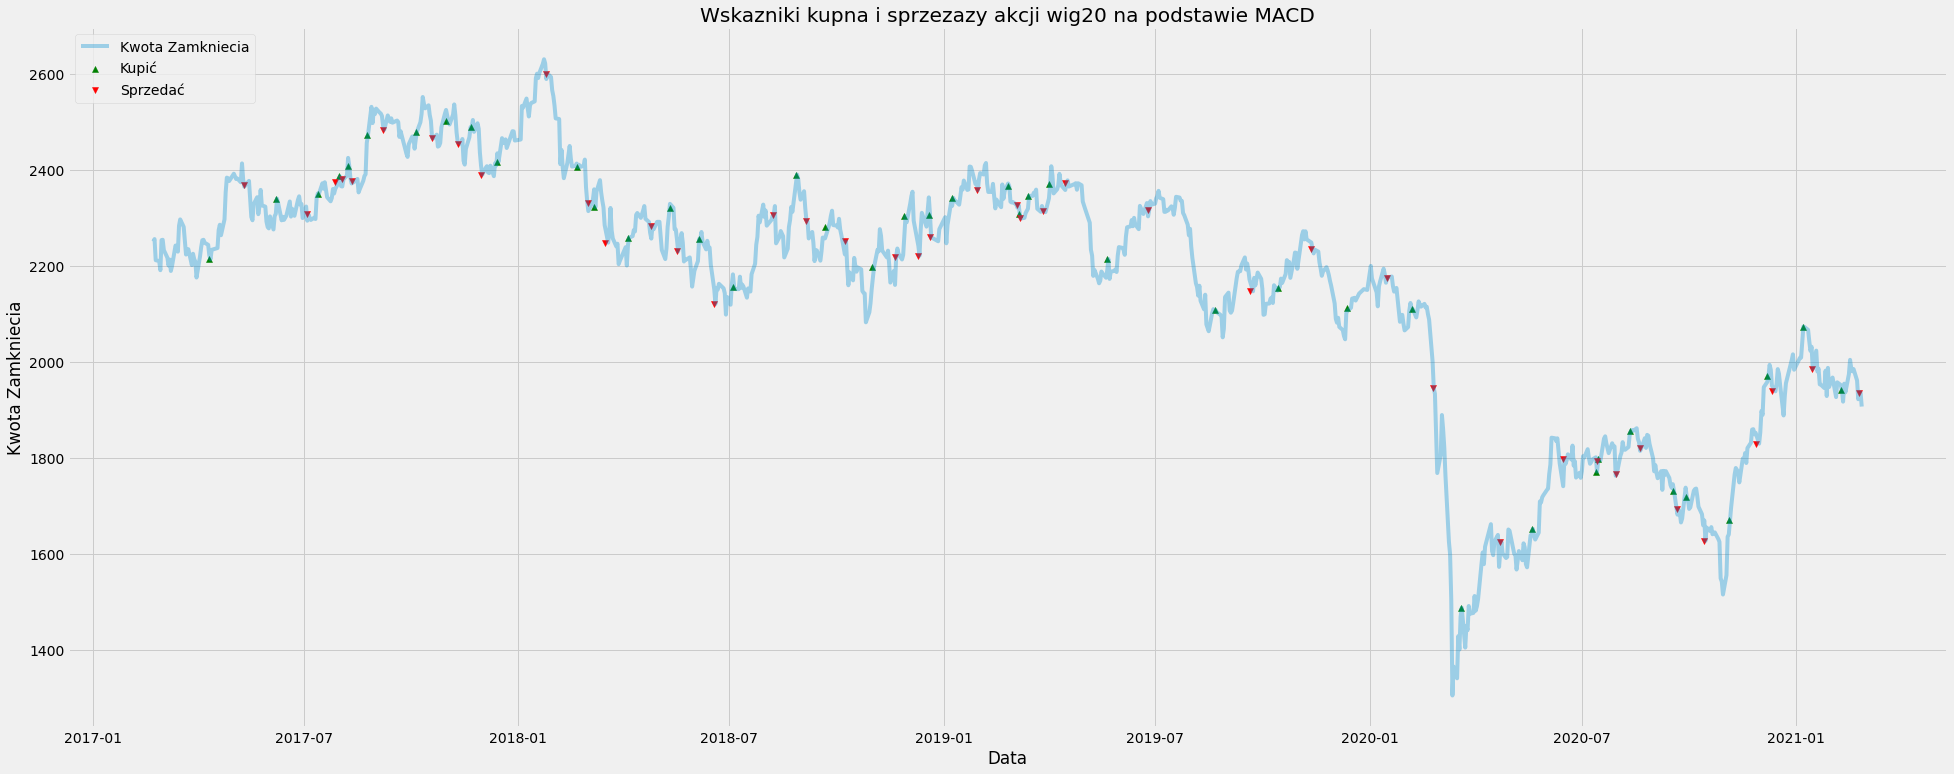

In [ ]:
#Wizualizacja kiedy kupic i sprzedac akcje MFI
plt.figure(figsize=(30, 12))
plt.scatter(new_df.index, new_df['Sygnal_Kupna_MFI'], color = 'green', label='Sygnał kupna MFI', marker="P", alpha=1)
plt.scatter(new_df.index, new_df['Sygnal_Sprzedazy_MFI'], color = 'red', label='Sygnał sprzedaży MFI', marker='X', alpha=1)
plt.plot(new_df['Zamkniecie'], label='Kwota Zamkniecia', alpha=0.35)
plt.title('Wskazniki kupna i sprzezazy akcji WIG20 na podstawie MFI')
plt.xlabel('Data')
plt.ylabel('Kwota Zamkniecia')
plt.legend(loc = 'upper left')
plt.show()
# Wykres do porównania
#Wizualizacja kiedy kupic i sprzedac akcje MACD
plt.figure(figsize=(30, 12))
plt.scatter(df.index, df['Sygnal_Kupna'], color = 'green', label='Kupić', marker='^', alpha=1)
plt.scatter(df.index, df['Sygnal_Sprzedazy'], color = 'red', label='Sprzedać', marker='v', alpha=1)
plt.plot(df['Zamkniecie'], label='Kwota Zamkniecia', alpha=0.35)
plt.title('Wskazniki kupna i sprzezazy akcji wig20 na podstawie MACD')
plt.xlabel('Data')
plt.ylabel('Kwota Zamkniecia')
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
# Stworzenie nowej funkcji która na podstawie MFI oraz MACD wyznaczy kiedy kupić lub sprzedać akcje
def buy_sell_macd_mfi(data, high, low, budget):
  buy_signal = []
  sell_signal = []
  wallet = 0
  flag = 0            #zmienia sie tylko przy transakcji
  time_period = 0

  for i in range(len(data)):
    if time_period > 0:
      time_period -= 1
    if data['MFI'][i] > high or data['MACD'][i] < data['SIGNAL'][i]:
      buy_signal.append(np.nan)
      if flag != 0 and time_period == 0:
        sell_signal.append(data['Zamkniecie'][i+1])
        budget = round(wallet * data['Zamkniecie'][i+1], 2)
        flag = 0
        time_period = 10
      else:
        sell_signal.append(np.nan)
    elif data['MFI'][i] < low or data['MACD'][i] > data['SIGNAL'][i]:
      if flag != 1 and time_period == 0:
        buy_signal.append(data['Zamkniecie'][i+1])
        wallet = budget/data['Zamkniecie'][i+1]
        flag = 1
        time_period = 10
      else:
        buy_signal.append(np.nan)
      sell_signal.append(np.nan)
    else:
      buy_signal.append(np.nan)
      sell_signal.append(np.nan)
  
  return (buy_signal, sell_signal, budget)

In [ ]:
#Nowe sygnały kupna i sprzedaży
mfi_results = buy_sell_macd_mfi(new_df, 70, 30, 1000)
new_df['Sygnal_Kupna_MFI'] = mfi_results[0]
new_df['Sygnal_Sprzedazy_MFI'] = mfi_results[1]
budget2 = mfi_results[2]
budget2

1194.6